In [1]:
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import pickle
from EEGNet_function import EEGNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import pandas as pd

## Functions

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

### data preprocessing

In [3]:
#%% P300 Stack
def p300_stack(data, nStack):
    # result = np.array()
    ind_toDelete = range(nStack)
    result = np.mean(data[0:nStack,:,:,:], axis=0, keepdims=True)
    data = np.delete(data,ind_toDelete,axis=0)
    while data.shape[0] >= nStack:
        tmp = np.mean(data[0:nStack,:,:,:], axis=0, keepdims=True)
        result = np.vstack([result, tmp])
        data = np.delete(data,ind_toDelete,axis=0)
        # print(data.shape)
    if (data.shape[0] > 0):
        tmp = np.mean(data[0:data.shape[0],:,:,:], axis=0, keepdims=True)
        result = np.vstack([result, tmp])
        ind_toDelete = range(data.shape[0])
        data = np.delete(data,ind_toDelete,axis=0)
    return result


#%% random
def random_trials(full_data, output_size, axis_to_choose):
    # Create a sample array

    # Randomly select an index from each column
    random_indices = np.random.choice(full_data.shape[axis_to_choose], output_size, replace=False)
    # Use the selected indices to access the data
    selected_data = np.take(full_data, indices=random_indices, axis=axis_to_choose)
    return selected_data

# filtering
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, lowcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  b, a = butter(order, low, btype='low')
  y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
  return y

def butter_highpass_filter(data, highcut, fs, order):
  nyq = fs/2
  high = highcut/nyq
  b, a = butter(order, high, btype='high')
  y = filtfilt(b, a, data) # zero-phase filter
  return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  high = highcut/nyq
  b, a = butter(order, [low, high], btype='band')
  # demean before filtering
  meandat = np.mean(data, axis=1)
  data = data - meandat[:, np.newaxis]
  y = filtfilt(b, a, data)
  return y

# re-sample
def down_sample(data,ogFs,targetFreq=256):
    q = int(np.floor(ogFs/targetFreq))
    data = signal.decimate(data,q,axis=1)
    return data

def loadPickle(pklDir):
    with open(pklDir,'rb') as fp:
        dd = pickle.load(fp)
        return dd
    
def reshape2Input(a):
    newshape = (a.shape[2], 1, a.shape[0], a.shape[1])  # trials , 1 , EEG_channels , sample_points
    return a.reshape(newshape)

def saveResult(df, save_dir):
    df.to_csv(save_dir)


In [4]:
def EEGNet_fit(folder_dir, random_select_trials = False, pkl_name='unname', logs_dir='logs', K=None, startPt=0, epoch_length=1000):
    '''data'''
    dictData = loadPickle(f"{folder_dir}/{pkl_name}")
    targetEEG_train = reshape2Input(dictData['targetEEG_train'])[
        :, :, :, startPt:startPt+epoch_length]
    targetEEG_test = reshape2Input(dictData['targetEEG_test'])[
        :, :, :, startPt:startPt+epoch_length]
    nontargetEEG_train = reshape2Input(dictData['nontargetEEG_train'])[
        :, :, :, startPt:startPt+epoch_length]
    nontargetEEG_test = reshape2Input(dictData['nontargetEEG_test'])[
        :, :, :, startPt:startPt+epoch_length]
    # Decide which of the above data has more trials,
    # and randomly choose the trials form larger one.
    
    # print('targetEEG_train.shape:',targetEEG_train.shape)
    # targetEEG_train = p300_stack(targetEEG_train, 5)
    # print('targetEEG_train.shape:',targetEEG_train.shape)
    # print('targetEEG_test.shape:',targetEEG_test.shape)
    # targetEEG_test = p300_stack(targetEEG_test, 5)
    # print('targetEEG_test.shape:',targetEEG_test.shape)
    # print('nontargetEEG_train.shape:',nontargetEEG_train.shape)
    # nontargetEEG_train = p300_stack(nontargetEEG_train, 5)
    # print('nontargetEEG_train.shape:',nontargetEEG_train.shape)
    # print('nontargetEEG_test.shape:',nontargetEEG_test.shape)
    # nontargetEEG_test = p300_stack(nontargetEEG_test, 5)
    # print('nontargetEEG_test.shape:',nontargetEEG_test.shape)

    if(random_select_trials==True):
        if(targetEEG_train.shape[0] > nontargetEEG_train.shape[0]):
            targetEEG_train = random_trials(targetEEG_train, nontargetEEG_train.shape[0], 0)
        elif(targetEEG_train.shape[0] < nontargetEEG_train.shape[0]):
            nontargetEEG_train = random_trials(nontargetEEG_train, targetEEG_train.shape[0], 0)
        else:
            pass
        if(targetEEG_test.shape[0] > nontargetEEG_test.shape[0]):
            targetEEG_test = random_trials(targetEEG_test, nontargetEEG_test.shape[0], 0)
        elif(targetEEG_test.shape[0] < nontargetEEG_test.shape[0]):
            nontargetEEG_test = random_trials(nontargetEEG_test, targetEEG_test.shape[0], 0)
        else:
            pass
    epochs_train = np.concatenate((targetEEG_train, nontargetEEG_train), axis=0)
    epochs_test = np.concatenate((targetEEG_test, nontargetEEG_test), axis=0)
    
    '''Label'''
    encoder = OneHotEncoder(sparse=False)
    y_train = np.ones((targetEEG_train.shape[0]))
    y_train = np.concatenate((y_train, np.ones(nontargetEEG_train.shape[0])+1))
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = np.ones((targetEEG_test.shape[0]))
    y_test = np.concatenate((y_test, np.ones(nontargetEEG_test.shape[0])+1))
    y_test = encoder.fit_transform(y_test.reshape(-1, 1))
    
    '''shuffle'''
    num_samples = epochs_train.shape[0]
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    epochs_train = epochs_train[shuffled_indices, :, :, :]
    y_train = y_train[shuffled_indices,:]
    num_samples = epochs_test.shape[0]
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    epochs_test = epochs_test[shuffled_indices, :, :, :]
    y_test = y_test[shuffled_indices,:]
    print('y_train.shape:', y_train.shape)
    print('y_test.shape:', y_test.shape)
    print('epochs_train.shape:', epochs_train.shape)
    print('epochs_test.shape:', epochs_test.shape)
    savingFoldername = 'data_check'
    if not os.path.isdir(f'./results/{savingFoldername}'):
        os.mkdir(f'./results/{savingFoldername}')
    saveResult(pd.DataFrame(y_train), f'./results/{savingFoldername}/y_train.csv')
    saveResult(pd.DataFrame(y_test), f'./results/{savingFoldername}/y_test.csv')
    
    history_list = list()
    if (K == None):
        pkl_no_ext = ".".join(pkl_name.split(".")[:-1])
        # history = model.fit(epochs_train, y_train, epochs_test, y_test)
        model = EEGNet(input_shape=(1, epochs_train.shape[2], epochs_train.shape[3]),
                   loss='categorical_crossentropy',
                   epochs=50,
                   batch_size=300,
                   kernLength=125,  # Half of sampling rate
                   lr=0.0005,
                   min_lr=0.0001,
                   log_path=f'{logs_dir}/log_{pkl_no_ext}',
                   log_path_TB=f'{logs_dir}_TB/log_{pkl_no_ext}_TB',
                   model_name=f'EEGNet_{pkl_no_ext}',
                   F1=16,
                   avgPoolSize_b1=(1, 4),
                   avgPoolSize_b2=(1, 8))
        history = model.fit(epochs_train, y_train, epochs_test, y_test)
        history_list.append(history)
        return history_list
    else:
        dataSet = np.concatenate([epochs_train, epochs_test])
        y = np.concatenate([y_train, y_test])
        print(f'KFold Applied! dataSet:{dataSet.shape}  y:{y.shape}')
        kf = KFold(n_splits=K, shuffle=True, random_state=5)
        kf.get_n_splits(dataSet, y)
        print(kf)
        for i, (train_index, test_index) in enumerate(kf.split(dataSet)):
            pkl_no_ext = ".".join(pkl_name.split(".")[:-1])
            model = EEGNet(input_shape=(1, epochs_train.shape[2], epochs_train.shape[3]),
                   loss='categorical_crossentropy',
                   epochs=50,
                   batch_size=300,
                   kernLength=125,  # Half of sampling rate
                   lr=0.0005,
                   min_lr=0.0001,
                   log_path=f'{logs_dir}/log_{pkl_no_ext}/Fold_{i}',
                   log_path_TB=f'{logs_dir}_TB/log_{pkl_no_ext}_TB',
                   model_name=f'EEGNet_{pkl_no_ext}_Fold{i}',
                   F1=16,
                   avgPoolSize_b1=(1, 4),
                   avgPoolSize_b2=(1, 8))
            epochs_train = dataSet[train_index, :, :, :]
            epochs_test = dataSet[test_index, :, :, :]
            y_train = y[train_index, :]
            y_test = y[test_index, :]
            history = model.fit(epochs_train, y_train, epochs_test, y_test)
            history_list.append(history)
        return history_list

def EEGNet_fit_specificCHs(folder_dir, pkl_name='unname', logs_dir='logs', K=None, startPt=0, epoch_length=1000):
    '''data'''
    ind_CHs = [31]
    dictData = loadPickle(f"{folder_dir}/{pkl_name}")
    targetEEG_train = reshape2Input(dictData['targetEEG_train'])[
        :, :, ind_CHs, startPt:startPt+epoch_length]
    targetEEG_test = reshape2Input(dictData['targetEEG_test'])[
        :, :, ind_CHs, startPt:startPt+epoch_length]
    nontargetEEG_train = reshape2Input(dictData['nontargetEEG_train'])[
        :, :, ind_CHs, startPt:startPt+epoch_length]
    nontargetEEG_test = reshape2Input(dictData['nontargetEEG_test'])[
        :, :, ind_CHs, startPt:startPt+epoch_length]
    epochs_train = np.concatenate(
        (targetEEG_train, nontargetEEG_train), axis=0)
    epochs_test = np.concatenate((targetEEG_test, nontargetEEG_test), axis=0)
    
    '''Label'''
    encoder = OneHotEncoder(sparse=False)
    y_train = np.ones((targetEEG_train.shape[0]))
    y_train = np.concatenate((y_train, np.ones(nontargetEEG_train.shape[0])+1))
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = np.ones((targetEEG_test.shape[0]))
    y_test = np.concatenate((y_test, np.ones(nontargetEEG_test.shape[0])+1))
    y_test = encoder.fit_transform(y_test.reshape(-1, 1))
    
    '''shuffle'''
    num_samples = epochs_train.shape[0]
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    epochs_train = epochs_train[shuffled_indices, :, :, :]
    y_train = y_train[shuffled_indices, :]
    num_samples = epochs_test.shape[0]
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    epochs_test = epochs_test[shuffled_indices, :, :, :]
    y_test = y_test[shuffled_indices, :]
    print('epochs_train.shape:', epochs_train.shape)
    print('epochs_test.shape:', epochs_test.shape)
    print('y_train:', y_train.shape)
    print('y_test.shape:', y_test.shape)
    shuffled_indices = np.arange(num_samples)
    model = EEGNet(input_shape=(1, epochs_train.shape[2], epochs_train.shape[3]),
                   loss='categorical_crossentropy',
                   epochs=40,
                   batch_size=300,
                   kernLength=125,  # Half of sampling rate
                   lr=0.0005,
                   min_lr=0.0001,
                   log_path=f'{logs_dir}/log_{pkl_name}',
                   model_name=f'EEGNet_{pkl_name}',
                   F1=16,
                   avgPoolSize_b1=(1, 8),
                   avgPoolSize_b2=(1, 8))
    history_list = list()
    if (K == None):
        history = model.fit(epochs_train, y_train, epochs_test, y_test)
        history_list.append(history)
        return history_list
    else:
        dataSet = np.concatenate([epochs_train, epochs_test])
        y = np.concatenate([y_train, y_test])
        print(f'KFold Applied! dataSet:{dataSet.shape}  y:{y.shape}')
        kf = KFold(n_splits=K)
        kf.get_n_splits(dataSet, y)
        print(kf)
        for i, (train_index, test_index) in enumerate(kf.split(dataSet)):
            epochs_train = dataSet[train_index, :, :, :]
            epochs_test = dataSet[test_index, :, :, :]
            y_train = y[train_index, :]
            y_test = y[test_index, :]
            history = model.fit(epochs_train, y_train, epochs_test, y_test)
            history_list.append(history)
        return history_list

def EEGNet_fit_folder(folder_dir, logs_dir='logs', ch_set='all', K=None, startPt=0,
                      epoch_length=1000, savingFoldername='folder', pltfilename='sess', random_select_trials = False):
    data_list = os.listdir(folder_dir)[0:2]
    data_list = [os.listdir(folder_dir)[0]]
    history_list = list()
    f, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax = ax.ravel()
    for i in range(len(data_list)):
        pkl = data_list[i]
        print("current data: ",pkl)
        pickle_dir = f'{folder_dir}/{pkl}'
        if (ch_set == '20ch'):
            history = EEGNet_fit_specificCHs(folder_dir, pkl_name=pkl, logs_dir=logs_dir,
                                      startPt=startPt, epoch_length=epoch_length, K=K)
        else:
            history = EEGNet_fit(folder_dir, random_select_trials=random_select_trials, pkl_name=pkl, logs_dir=logs_dir,
                                 startPt=startPt, epoch_length=epoch_length, K=K)
        history_list.append(history)

        '''Loss Curve Plot'''
        for j, fold in enumerate(history):
            if (j == 0):
                ax[i].plot(fold.history['loss'], '-', color='#1f77b4',
                           label='train')  # loss presents the train_loss
                ax[i].plot(fold.history['val_loss'], '-',
                           color='#ff7f0e', label='validation')
            else:
                # loss presents the train_loss
                ax[i].plot(fold.history['loss'], '-', color='#1f77b4',)
                ax[i].plot(fold.history['val_loss'], '-', color='#ff7f0e',)
            pkl_no_ext = ".".join(pkl.split(".")[:-1])
            ax[i].set_title(pkl_no_ext)
            ax[i].set_ylabel('loss')
            # ax[i].set_xlim([0,40])
            ax[i].set_ylim([0, 1.5])
            ax[i].set_yticks([0, 0.5, 1.0, 1.5])
            ax[i].set_xlabel('#iter')
    ax[-1].legend(bbox_to_anchor=(-5., -0.4, 2, .102),
                  loc=0, ncol=3, mode="expand", borderaxespad=0)
    plt.tight_layout()
    if not os.path.isdir(f'./results/{savingFoldername}'):
        os.mkdir(f'./results/{savingFoldername}')
    plt.savefig(f'./results/{savingFoldername}/{pltfilename}.png')
    return history_list, ax

## Main

current data:  sub01.pkl
y_train.shape: (600, 2)
y_test.shape: (1680, 2)
epochs_train.shape: (600, 1, 32, 150)
epochs_test.shape: (1680, 1, 32, 150)
KFold Applied! dataSet:(2280, 1, 32, 150)  y:(2280, 2)
KFold(n_splits=5, random_state=5, shuffle=True)


c:\Users\NESS\.conda\envs\TFGPU_2\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\NESS\.conda\envs\TFGPU_2\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 32, 150)] 0                                            
__________________________________________________________________________________________________
b1_Conv2D (Conv2D)              (None, 16, 32, 150)  2000        input_1[0][0]                    
__________________________________________________________________________________________________
b1_BM1 (BatchNormalization)     (None, 16, 32, 150)  600         b1_Conv2D[0][0]                  
__________________________________________________________________________________________________
b1_DeConv2D (DepthwiseConv2D)   (None, 32, 1, 150)   1024        b1_BM1[0][0]                     
______________________________________________________________________________________________

ValueError: Unable to create dataset (name already exists)

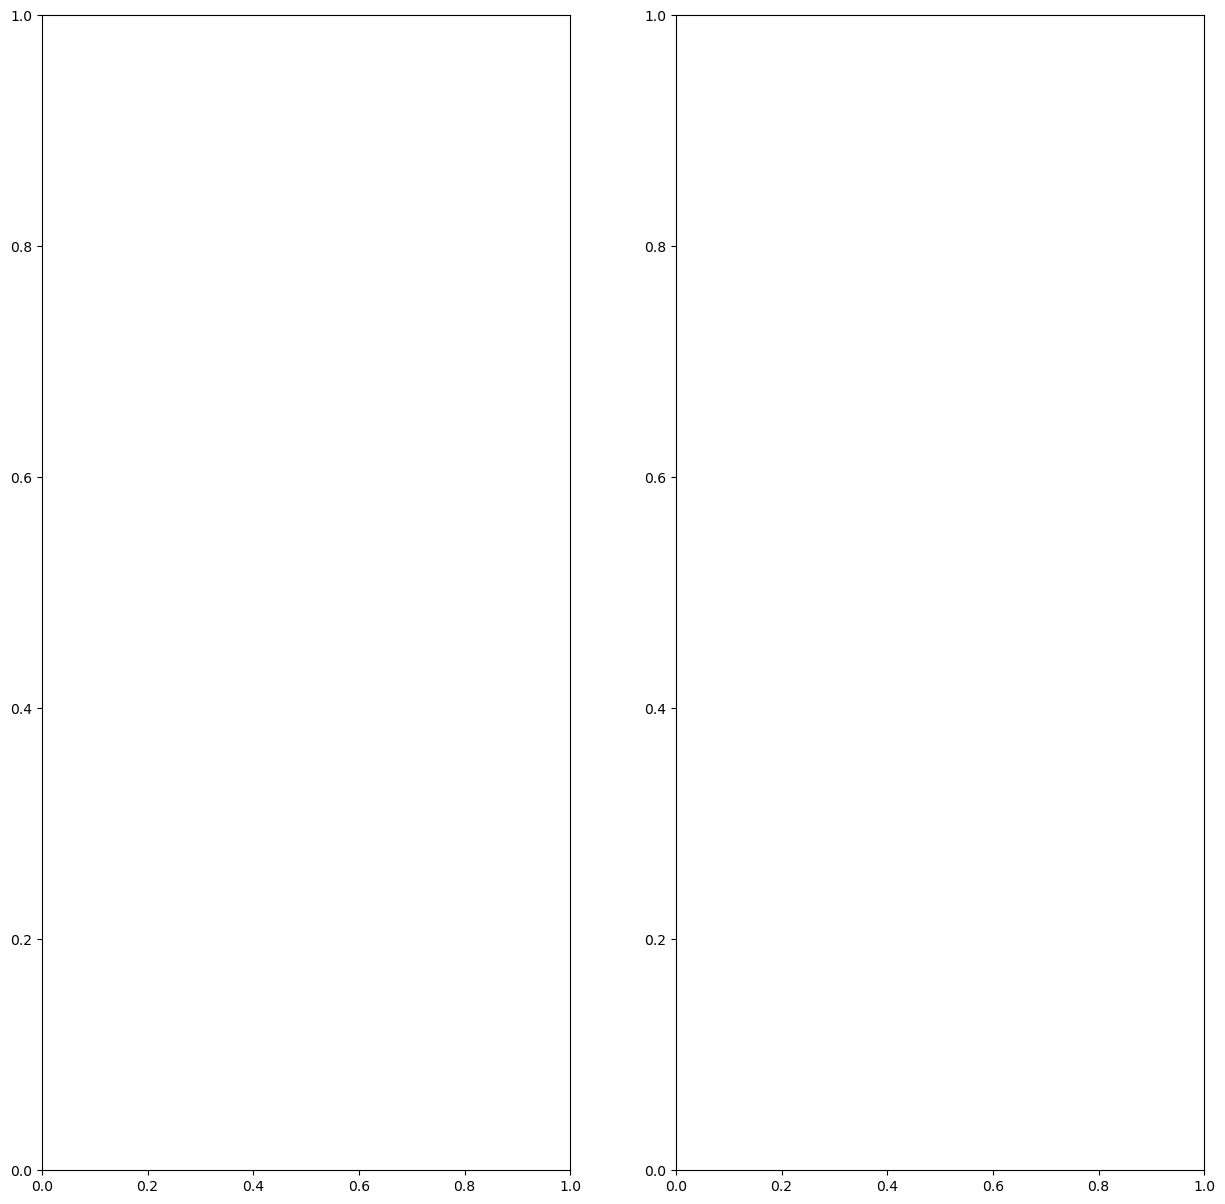

In [5]:
folder_dir = './organized'
data_list = os.listdir(folder_dir)
# pkl_name = data_list[0]
frame = [0, 150]
startPt = frame[0]
epoch_length = frame[1]-frame[0]
K = 5
logs_dir = 'logs'
savingFoldername = 'test for 0425 EEGNet tutorial'
filename = 'test'

history_list, lossCurve = EEGNet_fit_folder(folder_dir, logs_dir='logs', ch_set='all', K=K, startPt=startPt,epoch_length=epoch_length,
                                             savingFoldername=savingFoldername, pltfilename=filename, random_select_trials=True)


last_result = list()
for i, history in enumerate(history_list):
    for j, fold in enumerate(history):
        DF = pd.DataFrame(fold.history)
        if (j==0):
            col = DF.columns.tolist()
            init = np.zeros(len(col)).tolist()
            avg_fold = pd.Series(init, col)
        avg_fold += DF.iloc[-1, :]
    avg_fold = avg_fold / (j+1)
    last_result.append(avg_fold)
last_result = pd.DataFrame(last_result, index=None)
last_result = last_result.reset_index(drop=True)

if not os.path.isdir(f'./results/{savingFoldername}'):
    os.mkdir(f'./results/{savingFoldername}')
saveResult(last_result, f'./results/{savingFoldername}/{filename}.csv')

last_result = list()
for i, history in enumerate(history_list):
    for j, fold in enumerate(history):
        DF = pd.DataFrame(fold.history)
        if (j==0):
            col = DF.columns.tolist()
            init = np.zeros(len(col)).tolist()
            avg_fold = pd.Series(init, col)
        avg_fold += DF.iloc[30, :]
    avg_fold = avg_fold / (j+1)
    last_result.append(avg_fold)
last_result = pd.DataFrame(last_result, index=None)
last_result = last_result.reset_index(drop=True)

if not os.path.isdir(f'./results/{savingFoldername}'):
    os.mkdir(f'./results/{savingFoldername}')
saveResult(last_result, f'./results/{savingFoldername}/ES_{filename}.csv')

last_result = list()
for i, history in enumerate(history_list):
    for j, fold in enumerate(history):
        DF = pd.DataFrame(fold.history)
        if (j==0):
            col = DF.columns.tolist()
            init = np.zeros(len(col)).tolist()
            avg_fold = pd.Series(init, col)
        avg_fold += DF.iloc[0, :]
    avg_fold = avg_fold / (j+1)
    last_result.append(avg_fold)
last_result = pd.DataFrame(last_result, index=None)
last_result = last_result.reset_index(drop=True)

if not os.path.isdir(f'./results/{savingFoldername}'):
    os.mkdir(f'./results/{savingFoldername}')
saveResult(last_result, f'./results/{savingFoldername}/1st_Iter_{filename}.csv')
plt.show()
del lossCurve